In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib inline

In [6]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, jacfwd, jit, make_jaxpr, random, value_and_grad, vmap
from jax.example_libraries.optimizers import adam
from jax.lax import cond
from jax.nn import softplus, tanh
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
import numpy as np

In [ ]:
def initialize_mlp(sizes, key):
    keys = random.split(key, len(sizes))

    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


def net(parameters, x):
    activations = x
    for w, b in parameters[:-1]:
        activations = tanh(jnp.dot(w, activations) + b)
    
    w, b = parameters[-1]
    u = jnp.sum(jnp.dot(w, activations) + b)
    return u

# Finite Differences

In [41]:
x_step = 0.01  # distance between points of solution
x_begin = 0.0
x_end = 1.0
x = jnp.arange(x_begin, x_end + x_step, x_step)
n_points = x.shape[0]
vel = 1.0 # velocity throughout the entire domain


# construct derivative matrix
H = np.zeros((n_points, n_points))
H[0,:2] = [-1,1]    # forward difference
H[-1,-2:] = [-1,1]  # backward difference

for i in range(1,n_points-1):
    H[i,i-1:i+2] = [-1, 0, 1] # central difference
H = jnp.array(H)

# step sizes
Dx = np.repeat(1/(2*x_step),n_points) # points for central differences are spaced by two steps
Dx[0] = 1/x_step # points for forward and backwards differences are spaced by one step
Dx[-1] = 1/x_step
Dx = jnp.array(Dx)


def permeability(x):
    return cond(x < 0.5, lambda _: 1.0, lambda _: 0.5, None)

permeability_x = vmap(permeability)(x)
y = jnp.repeat(vel, n_points)

A = H * Dx

pressure = jnp.linalg.pinv(A) @ y

ValueError: not enough values to unpack (expected 2, got 1)

Text(0, 0.5, 'u(x)')

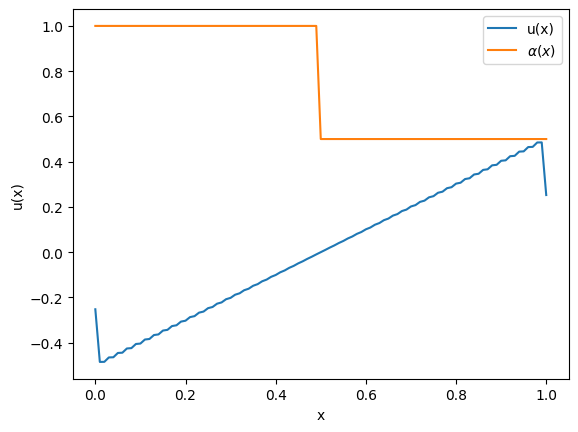

In [40]:
fig, ax = plt.subplots()
ax.plot(x, pressure, label="u(x)")
ax.plot(x, permeability_x, label=r"$\alpha(x)$")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("u(x)")


In [37]:
ax

<Axes: >

# Pressure Network

100%|██████████| 100000/100000 [05:13<00:00, 318.90it/s]


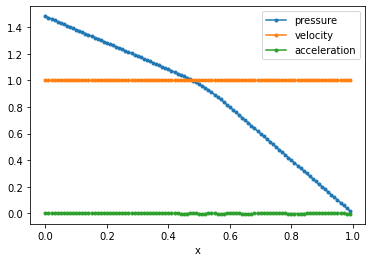

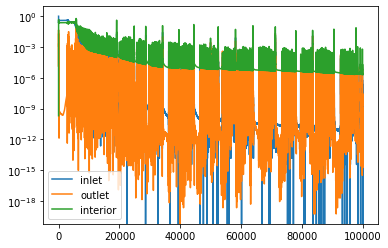

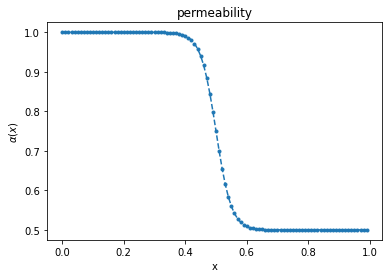

In [ ]:
key = random.PRNGKey(0)
layer_sizes = [1, *[64]*4, 1]
params = initialize_mlp(layer_sizes,key)

init_fun, update_fun, get_params = adam(1e-3)
opt_state = init_fun(params)

x = jnp.arange(0.0,1.0,0.01)

# def a(x):
#     return cond(x < 0.5, lambda _: 1.0, lambda _: 0.5, None)

def a(x):
  a_min = 1.0
  a_jump = -0.5
  x_jump = 0.5
  return jnp.tanh((x-x_jump)*20.0)*(a_jump/2) + (a_min + a_jump/2)

def forward(params,x):
           
    def f(x):
        u, dudx = value_and_grad(net,argnums=1)(params,x)
        return -a(x)*dudx

    v, dvdx = value_and_grad(f)(x)
    u = net(params,x)

    return u, v, dvdx

@jit
def update(opt_state):

    params = get_params(opt_state)

    def loss_inlet(params):
        u, v ,dvdx = forward(params, 0.0)
        return (v - 1.0)**2

    def loss_outlet(params):
        u, v ,dvdx = forward(params, 1.0)
        return (u-0.0)**2

    def loss_interior(params):
        u, v ,dvdx = vmap(forward,(None,0),0)(params, x)
        #return 0.0
        return jnp.sum((dvdx-0.0)**2) / x.shape[0]

    def loss(params):
        l1 = loss_inlet(params)
        l2 = loss_outlet(params)
        l3 = loss_interior(params)
        return l1+l2+l3

    loss_1 = loss_inlet(params)
    loss_2 = loss_outlet(params)
    loss_3 = loss_interior(params)
    
    grads = grad(loss)(params)

    opt_state = update_fun(0, grads,opt_state)
    
    return (loss_1,loss_2,loss_3), opt_state

losses_1 = []
losses_2 = []
losses_3 = []

for i in tqdm(range(100000)):
    (loss_1,loss_2,loss_3), opt_state = update(opt_state)
    losses_1.append(loss_1)
    losses_2.append(loss_2)
    losses_3.append(loss_3)



params = get_params(opt_state)
u, v, dvdx = vmap(forward,(None,0),0)(params, x)

fig, ax = plt.subplots()
ax.plot(x,u,marker=".",label="pressure")
ax.plot(x,v, marker=".",label="velocity")
ax.plot(x,dvdx,marker=".",label="acceleration")
ax.set_xlabel("x")
ax.legend()

fig, ax = plt.subplots()
ax.plot(losses_1,label="inlet")
ax.plot(losses_2,label="outlet")
ax.plot(losses_3,label="interior")
ax.set_yscale("log")
ax.legend()

try:
  A = a(x)
except Exception:  
  A = vmap(a)(x)

fig, ax = plt.subplots()
ax.plot(x,A,marker=".",linestyle="dashed")
ax.set_title("permeability")
ax.set_xlabel("x")
ax.set_ylabel(r"$\alpha(x)$");


# Premeablity functions 1D

100%|██████████| 10000/10000 [00:07<00:00, 1290.28it/s]


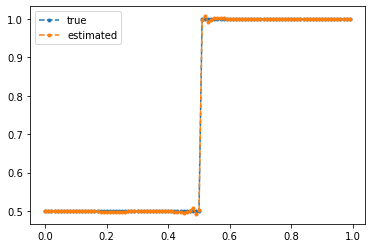

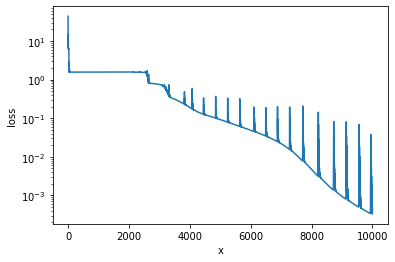

In [ ]:
import numpy as np

A = jnp.ones_like(x)
A = A.at[:51].set(0.5)



layer_sizes = [1, *[64]*4, 1]
params = initialize_mlp(layer_sizes,key)

init_fun, update_fun, get_params = adam(1e-3)
opt_state = init_fun(params)


@jit
def update(opt_state):

    def loss(params):
      A_estimated = vmap(net,(None,0),0)(params, x)
      return jnp.sum((A_estimated - A)**2)

    params = get_params(opt_state)
    value, grads = value_and_grad(loss)(params)
    opt_state = update_fun(0, grads, opt_state)
    
    return value, opt_state

losses = []

for i in tqdm(range(10000)):
    value, opt_state = update(opt_state)
    losses.append(value)

params = get_params(opt_state)
A_estimated = vmap(net, (None,0),0)(params, x)

fig, ax = plt.subplots()
ax.plot(x, A,marker=".",linestyle="dashed",label="true")
ax.plot(x, A_estimated,marker=".",linestyle="dashed",label="estimated")
ax.set_xlabel=("x")
ax.set_xlabel=(r"$\alpha(x)$")
ax.legend()

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("x")
ax.set_ylabel("loss")
ax.set_yscale("log")





# Permeablity function 2D

100%|██████████| 100000/100000 [02:19<00:00, 716.76it/s]


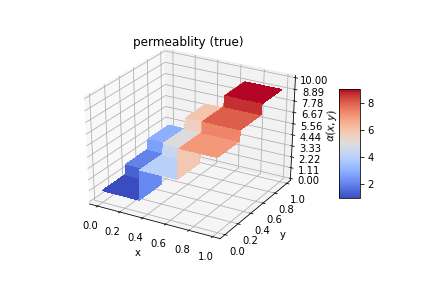

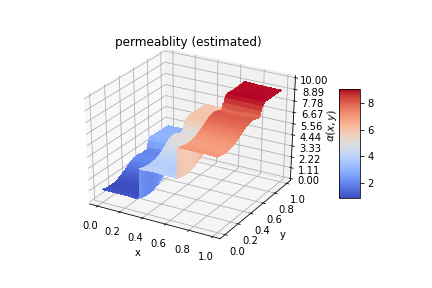

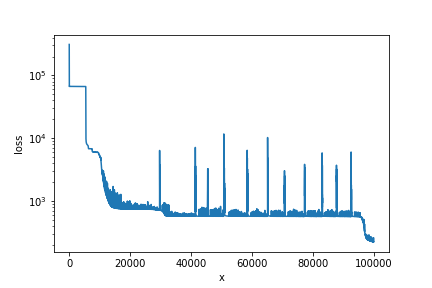

In [ ]:
def permeablity(x, y):
        A = jnp.arange(1,10).reshape(3,3)
        block_width = 1/3
        x_idx = jnp.floor_divide(x, block_width).astype(int)
        y_idx = jnp.floor_divide(y, block_width).astype(int)
        return A[x_idx, y_idx]

x,y = jnp.meshgrid(jnp.arange(0.0, 1.0, 0.01),jnp.arange(0.0, 1.0, 0.01))
xy = jnp.stack((x,y),axis=2)

A_true = vmap(vmap(permeablity,(0,0),0),(1,1),1)(x,y)

layer_sizes = [2, *[64]*6, 1]
params = initialize_mlp(layer_sizes,key)

init_fun, update_fun, get_params = adam(1e-3)
opt_state = init_fun(params)

net_2d_batched = vmap(net,(None,0),0)
net_2d_batched = vmap(net_2d_batched,(None,1),1)

net_2d_batched(params,xy)

@jit
def update(opt_state):

    def loss(params):
      A_estimated = net_2d_batched(params, xy)
      return jnp.sum((A_estimated - A_true)**2)

    params = get_params(opt_state)
    value, grads = value_and_grad(loss)(params)
    opt_state = update_fun(0, grads, opt_state)
    
    return value, opt_state

losses = []

for i in tqdm(range(100000)):
    value, opt_state = update(opt_state)
    losses.append(value)

params = get_params(opt_state)
A_estimated = net_2d_batched(params, xy)


# heightmap pressure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    x, y, A_true, cmap=cm.coolwarm, linewidth=0, antialiased=False
)
ax.set_zlim(u.min(), u.max())
ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter("{x:.02f}")
ax.set_title("permeablity (true)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$\alpha(x,y)$")
ax.set_zlim((0.0,10.0))
fig.colorbar(surf, shrink=0.5, aspect=5)

# heightmap pressure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    x, y, A_estimated, cmap=cm.coolwarm, linewidth=0, antialiased=False
)
ax.set_zlim(u.min(), u.max())
ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter("{x:.02f}")
ax.set_title("permeablity (estimated)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$\alpha(x,y)$")
ax.set_zlim((0.0,10.0))
fig.colorbar(surf, shrink=0.5, aspect=5)

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("x")
ax.set_ylabel("loss")
ax.set_yscale("log")



# Gaussian Function

(100, 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


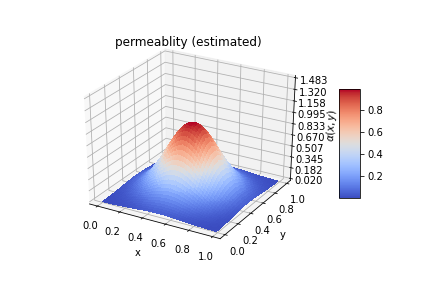

In [ ]:

def a(x):
  a = 1.0 # amplitude
  b = jnp.asarray((0.5,0.5)) # center
  c = 0.2 # std-deviation
  return a*jnp.exp(-jnp.sum((x-b)**2)/(2*c**2))

a = vmap(vmap(a,0,0), 1,1)

x,y = jnp.meshgrid(jnp.arange(0.0,1.0,0.01),jnp.arange(0.0,1.0,0.01))
xy = jnp.stack((x,y),axis=2)

A = a(xy)
print(A.shape)

# heightmap pressure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    x, y, A, cmap=cm.coolwarm, linewidth=0, antialiased=False
)
ax.set_zlim(u.min(), u.max())
ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter("{x:.02f}")
ax.set_title("permeablity (estimated)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$\alpha(x,y)$")
#ax.set_zlim((0.0,10.0))
fig.colorbar(surf, shrink=0.5, aspect=5)

